# Gyroscope Environment Testbed

## 1. Test Environment Class

## 1.1 Import and Load Environment

In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
from scipy.integrate import solve_ivp

In [2]:
class GyroscopeEnv(gym.Env):

    """
    GyroscopeEnv:
        GyroscopeEnv is a GYM environment for Quanser 3-DOF gyroscope. The gyroscope consists of a disk mounted 
        inside an inner gimbal which in turn is mounted inside an outer gimbal.
        The two gimbals are controlled by a RL controller, and the disk is controlled by a PID controller.
    
    State: 
        state = [x1, x2, x3, x4, x1_ref, x3_ref, w] (7 dimensions)
        Outer red gimbal:
            x1, or theta: angular position [rad]
            x2, or dot(theta): angular velocity [rad/s]
            x1_ref: angular position reference [rad]
            u1: motor voltage [V]
        Inner blue gimbal:
            x3, or phi: angular position [rad]
            x4, or dot(phi): angular velocity [rad/s]
            x3_ref: angular position reference [rad]
            u2: motor voltage [V]
        Golden disk:
            w: angular velocity [rad/s]
            u3: motor voltage [V]
        Mechanical constraints:
            motor voltage: [-10, 10] [V]
            gimbal velocity: [-100, 100] [rpm]
            disk velocity: [-300, 300] [rpm]        
    
    Observation:
        observation = [cos(x1), sin(x1), x2, cos(x3), sin(x3), x4, x1_ref, x3_ref, w] (9 dimensions)
        The angles have been replaced with their cosine and sine to prevent the discontinuity at -pi and pi.
        The observation space is thus larger than the state space.
        
    Action:
        action = [u1, u2]
        
    Initialization:
        Some versions of Gym may not support initialization with arguments, so initialize it manully with: 
        # create env
        env = GyroscopeEnv()
        env.init(simu_args = simu_args, reward_func = reward_func, reward_args = reward_args)
        # simu_args, with optional simulation step (dt), episode length (ep_len), and random seed (seed)
        simu_args = {'dt': 0.05, 'ep_len': 100, 'seed': 2}
        # reward_func, optional reward function, default value is 'Normalized'
        reward_func = 'Normalized'
        # reward_args, optional reward parameters
        reward_args = {'k': 0.05, 'qx2': 0.01, 'qx4': 0.01, 'pu1': 0.5, 'pu2': 0.5}
    """
    
    # ---------------------------------------------------------------------------------------------------- #
    # ------------------------------------------ Initialization ------------------------------------------ #
    # ---------------------------------------------------------------------------------------------------- #        
                
    def init(self, simu_args = {}, reward_func = 'Normalized', reward_args = {}):
        
        # Initialize mechanical parameters of the gyroscope
        self.init_gyro()
        
        # Initialize simulation parameters
        self.init_simu(**simu_args)
        
        # Initialize reward parameters
        self.init_reward(reward_func, reward_args)
        
        # State space, 7D
        self.state_bound = np.array([self.maxAngle, self.maxGimbalSpeed, self.maxAngle, self.maxGimbalSpeed, 
                                   self.maxAngle, self.maxAngle, self.maxDiskSpeed], dtype = np.float32)
        self.state_space = spaces.Box(low = -self.state_bound, high = self.state_bound, dtype = np.float32)
        
        # Observation space (normalized), 9D
        self.observation_bound = np.array([1.0] * 9, dtype = np.float32) 
        self.observation_space = spaces.Box(low = -self.observation_bound, high = self.observation_bound, 
                                            dtype = np.float32)
        
        # Action space (normalized), 2D
        self.action_bound = np.array([1.0] * 2, dtype = np.float32) 
        self.action_space = spaces.Box(low = -self.action_bound, high = self.action_bound, dtype = np.float32)
    
    # Initialize fixed parameters of the gyroscope
    def init_gyro(self):
        
        # Inertias in Kg*m2, from SP report page 23, table 2
        self.Jrx1 = 0.0179
        self.Jbx1 = 0.0019
        self.Jbx2 = 0.0008
        self.Jbx3 = 0.0012
        self.Jdx1 = 0.0028
        self.Jdx2 = 0.0056
        self.Jdx3 = 0.0056

        # Combined inertias to simplify equations, from SP report page 22, state space equations
        self.J1 = self.Jbx1 - self.Jbx3 + self.Jdx1 - self.Jdx3
        self.J2 = self.Jbx1 + self.Jdx1 + self.Jrx1
        self.J3 = self.Jbx2 + self.Jdx1

        # Motor constants, from SP report page 23, table 1
        self.Kamp = 0.5 # current gain, A/V
        self.Ktorque = 0.0704 # motor gain, Nm/A
        self.eff = 0.86 # motor efficiency
        self.nRed = 1.5 # red gearbox eatio
        self.nBlue = 1 # blue gearbox eatio
        self.KtotRed = self.Kamp * self.Ktorque * self.eff * self.nRed 
        self.KtotBlue = self.Kamp * self.Ktorque * self.eff * self.nBlue 
        
        # Physical constraints
        self.maxVoltage = 10 # V
        self.maxAngle = np.pi
        self.maxGimbalSpeed = 100 * 2 * np.pi / 60 # rad/s
        self.maxDiskSpeed = 300 * 2 * np.pi / 60 # rad/s
        
    # Initialize simulation parameters
    def init_simu(self, dt = 0.05, ep_len = 100, seed = 2, friction = False):
        
        # Gyroscope state and observation
        self.state = np.array([0] * 7)
        self.observe()

        # Time step in s
        self.dt = dt
        self.eval_per_dt = int(dt / 0.01) # run evaluation every 0.01s
        
        # Episode length and current episode
        self.ep_len = ep_len
        self.ep_cur = 0
        
        # Seed for random number generation
        self.seed(seed)
        self.viewer = None
        
        # Friction
        self.fvr = 0.002679 if friction else 0
        self.fcr = 0
        self.fvb = 0.005308 if friction else 0
        self.fcb = 0
        
    # Initialize reward parameters
    def init_reward(self, reward_func, reward_args):
                
        reward_dict = {
            'Quadratic': self.quad_reward,
            'Absolute': self.abs_reward,
            'Normalized': self.norm_reward,
            'Quadratic with ending penalty': self.quad_end_pen_reward,
            'Quadratic with penalty': self.quad_pen_reward,
            'Quadratic with exponential': self.quad_exp_reward,
            'Quadratic with bonus':self.quad_bon_reward,
            'Normalized with bonus': self.norm_bon_reward,
            'Sparse':self.sparse_reward
        }
        self.reward_func = reward_dict[reward_func]
        self.reward_args = reward_args

    # ---------------------------------------------------------------------------------------------------- #
    # ----------------------------------------------- Step ----------------------------------------------- #
    # ---------------------------------------------------------------------------------------------------- #
    
    # Simulate the environment fot one step dt, remember that u is normalized!!!
    def step(self, u):
        
        x1, x2, x3, x4, x1_ref, x3_ref, w = self.state
        u1, u2 = u

        # Increment episode
        self.ep_cur += 1

        # For quad_end_pen_reward, check if terminal state is reached
        if self.reward_func == self.quad_end_pen_reward and self.ep_cur == self.ep_len:
            self.reward_args['end_horizon'] = 1

        # run simulation for a step
        results = solve_ivp(
                    fun = self.dxdt, 
                    t_span = (0, self.dt), # solver starts with t = 0 and integrates until it reaches t = self.dt
                    y0 = [x1, x2, x3, x4], # initial state
                    method = 'RK45', 
                    t_eval = np.linspace(0, self.dt, self.eval_per_dt), # times at which to store the computed solution
                    args = (self.maxVoltage * u1, self.maxVoltage * u2) 
                )
        
        # evaluated states, each contains eval_per_dt points
        x1_eval = results.y[0]
        x2_eval = results.y[1]
        x3_eval = results.y[2]
        x4_eval = results.y[3]

        # keep only the last evaluation value
        x1 = x1_eval[-1]
        x2 = x2_eval[-1]
        x3 = x3_eval[-1]
        x4 = x4_eval[-1]
        
        # Angle error (normalized between pi and -pi to get smallest distance)
        x1_diff = self.angle_normalize(x1 - x1_ref)
        x3_diff = self.angle_normalize(x3 - x3_ref)
        
        # update state and observation
        self.state = np.array([x1, x2, x3, x4, x1_ref, x3_ref, w])
        self.observe()

        # Reward(float)
        reward = self.reward_func(x1_diff, x3_diff, x2, x4, u1, u2, **self.reward_args)
        
        # Done(bool): whether it’s time to reset the environment again.
        done = self.ep_cur > self.ep_len
        
        # Info(dict): diagnostic information useful for debugging. 
        info = {'state': self.state, 'observation': self.observation}
        
        return self.observation, reward, done, info
    
    # Compute the derivative of the state, here u is NOT normalized
    def dxdt(self, t, x, u1, u2):

        J1, J2, J3, Jdx3 = self.J1, self.J2, self.J3, self.Jdx3
        w = self.state[-1]

        # Convert input voltage to input torque
        T1, T2 = self.KtotRed * u1, self.KtotBlue * u2
    
        # Friction
        T1 = T1 - self.fvr*x[1] - self.fcr*np.sign(x[1])
        T2 = T2 - self.fvb*x[3] - self.fcb*np.sign(x[3])
        
        # Equations of motion 
        dx_dt = [0, 0, 0, 0]
        dx_dt[0] = x[1]
        dx_dt[1] = (T1+J1*np.sin(2*x[2])*x[1]*x[3]-Jdx3*np.cos(x[2])*x[3]*w)/(J2 + J1*np.power(np.sin(x[2]),2))
        dx_dt[2] = x[3]
        dx_dt[3] = (T2-J1*np.cos(x[2])*np.sin(x[2])*np.power(x[1],2)+Jdx3*np.cos(x[2])*x[1]*w)/J3
        
        return dx_dt        
    
    # ---------------------------------------------------------------------------------------------------- #
    # ---------------------------------------------- Reward ---------------------------------------------- #
    # ---------------------------------------------------------------------------------------------------- #
    
    def abs_reward(self, x1_diff, x3_diff, x2, x4, u1, u2, qx1 = 1, qx2 = 0.01, qx3 = 1, qx4 = 0.01, pu1 = 0, pu2 = 0):
        return -(qx1*abs(x1_diff) + qx3*abs(x3_diff) + qx2*abs(x2) + qx4*abs(x4) + pu1*abs(u1) + pu2*abs(u2))

    def norm_reward(self, x1_diff, x3_diff, x2, x4, u1, u2, k = 0.2, qx2 = 0, qx4 = 0, pu1 = 0, pu2 = 0):
        return -((abs(x1_diff)/k)/(1 + (abs(x1_diff)/k)) + (abs(x3_diff)/k)/(1 + (abs(x3_diff)/k)) + qx2*(x2**2) + qx4*(x4**2) + pu1*(u1**2) + pu2*(u2**2))

    def norm_bon_reward(self, x1_diff, x3_diff, x2, x4, u1, u2, k = 0.2, qx2 = 0, qx4 = 0, pu1 = 0, pu2 = 0, bound = 0.001, bonus = 1):
        return -((abs(x1_diff)/k)/(1 + (abs(x1_diff)/k)) + (abs(x3_diff)/k)/(1 + (abs(x3_diff)/k)) + qx2*(x2**2) + qx4*(x4**2) + pu1*(u1**2) + pu2*(u2**2) - bonus*(abs(x1_diff) <= bound or abs(x3_diff) <= bound))

    def quad_reward(self, x1_diff, x3_diff, x2, x4, u1, u2, qx1 = 1, qx2 = 0.01, qx3 = 1, qx4 = 0.01, pu1 = 0, pu2 = 0):
        return -(qx1*(x1_diff**2) + qx3*(x3_diff**2) + qx2*(x2**2) + qx4*(x4**2) + pu1*(u1**2) + pu2*(u2**2))

    def quad_exp_reward(self, x1_diff, x3_diff, x2, x4, u1, u2, qx1 = 1, qx2 = 0.01, qx3 = 1, qx4 = 0.01, pu1 = 0, pu2 = 0, eax1 = 10, ebx1 = 10, eax3 = 10, ebx3 = 10):
        return -(qx1*(x1_diff**2) + qx3*(x3_diff**2) + qx2*(x2**2) + qx4*(x4**2) + pu1*(u1**2) + pu2*(u2**2) + eax1*(1-np.exp(-ebx1*(x1_diff**2))) + eax3*(1-np.exp(-ebx3*(x3_diff**2))))

    def quad_end_pen_reward(self, x1_diff, x3_diff, x2, x4, u1, u2, qx1 = 1, qx2 = 0.01, qx3 = 1, qx4 = 0.01, pu1 = 0, pu2 = 0, sx1 = 10, sx3 = 10, end_horizon = 0):
        return -(qx1*(x1_diff**2) + qx3*(x3_diff**2) + qx2*(x2**2) + qx4*(x4**2) + pu1*(u1**2) + pu2*(u2**2) + end_horizon*(sx1*(x1_diff**2)+sx3*(x3_diff**2)))

    def quad_pen_reward(self, x1_diff, x3_diff, x2, x4, u1, u2, qx1 = 1, qx2 = 0.01, qx3 = 1, qx4 = 0.01, pu1 = 0, pu2 = 0, bound = 0.1, penalty = 50):
        return -(qx1*(x1_diff**2) + qx3*(x3_diff**2) + qx2*(x2**2) + qx4*(x4**2) + pu1*(u1**2) + pu2*(u2**2) + penalty*(abs(x1_diff) >= bound or abs(x3_diff) >= bound))

    def quad_bon_reward(self, x1_diff, x3_diff, x2, x4, u1, u2, qx1 = 1, qx2 = 0.01, qx3 = 1, qx4 = 0.01, pu1 = 0, pu2 = 0, bound = 0.1, bonus = 5):
        return -(qx1*(x1_diff**2) + qx3*(x3_diff**2) + qx2*(x2**2) + qx4*(x4**2) + pu1*(u1**2) + pu2*(u2**2) - bonus*(abs(x1_diff) <= bound or abs(x3_diff) <= bound))

    def sparse_reward(self, x1_diff, x3_diff, x2, x4, u1, u2, bound = 0.01, reward = 1):
        return  reward*(abs(x1_diff) <= bound and abs(x3_diff) <= bound)
    
    # ---------------------------------------------------------------------------------------------------- #
    # ---------------------------------------------- Helper ---------------------------------------------- #
    # ---------------------------------------------------------------------------------------------------- #
    
    # reset system to a given or random initial state
    def reset(self, x_0 = None):
        
        # reset state
        if x_0 is None:
            self.state = self.state_space.sample()
        else:
            self.state = x_0
        # update observation
        self.observe()
        # reset counter
        self.ep_cur = 0
        
        return self.observation
        
    # return normalized observation
    def observe(self):
        s = self.state
        self.observation = np.array([np.cos(s[0]), np.sin(s[0]), s[1]/self.maxGimbalSpeed, 
                                     np.cos(s[2]), np.sin(s[2]), s[3]/self.maxGimbalSpeed, 
                                     s[4]/self.maxAngle, s[5]/self.maxAngle, s[6]/self.maxDiskSpeed])
        return self.observation
    
    # Keep the angles between -lim and lim
    def angle_normalize(self, x, lim = np.pi):
        return ((x + lim) % (2 * lim)) - lim
    
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def render(self, mode='human'):
        return None

    def close(self):
        if self.viewer:
            
            self.viewer.close()
            self.viewer = None

## 1.2 Initialize the Environment

In [3]:
# Initialization args
simu_args = {
    'dt': 0.05,
    'ep_len': 100,
    'seed': 2
}
reward_func = 'Normalized'
reward_args = {
    'k': 0.05, 
    'qx2': 0.01, 
    'qx4': 0.01, 
    'pu1': 0.5, 
    'pu2': 0.5
}

# Create env
env = GyroscopeEnv()
env.init(simu_args = simu_args, reward_func = reward_func, reward_args = reward_args)

## 1.3 Run the Test with Simply Input

In [4]:
# Set initial state
x_0 = [0.5, 0.2, 0.5, 0, 0, 0, 200 * 2 * np.pi / 60]
# x_0 = [0,0,0,0,-np.pi,0,0]
observation = env.reset(x_0)

time = np.arange(0, 10, env.dt)
state_record = np.empty([len(time), len(x_0)])
reward_record = np.empty([len(time), 1])
action_record = np.empty([len(time), 2])

for i in range(len(time)):
    action = [0,0] 
    # action = env.action_space.sample()
    
    observation, reward, done, info = env.step(action)
    state_record[i] = env.state
    reward_record[i] = reward
    action_record[i] = action

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

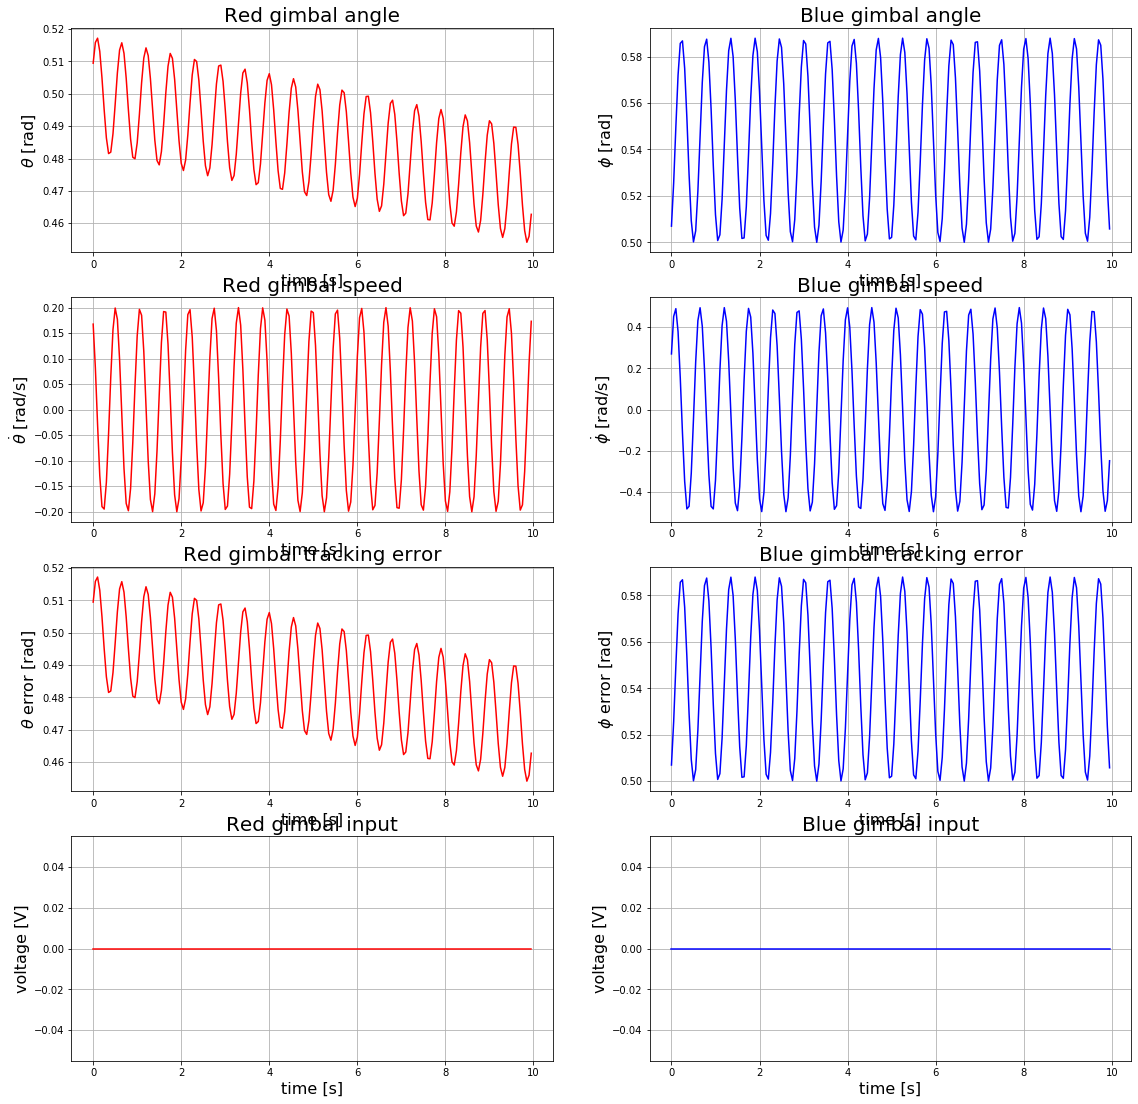

In [6]:
f, axs = plt.subplots(4,2,figsize=(19,19))

plt.subplot(4,2,1)
plt.title('Red gimbal angle',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\theta$ [rad]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,0],'r-')

plt.subplot(4,2,2)
plt.title('Blue gimbal angle',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\phi$ [rad]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,2],'b-')

plt.subplot(4,2,3)
plt.title('Red gimbal speed',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\dot \theta$ [rad/s]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,1],'r-')

plt.subplot(4,2,4)
plt.title('Blue gimbal speed',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\dot \phi$ [rad/s]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,3],'b-')

plt.subplot(4,2,5)
plt.title('Red gimbal tracking error',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\theta$ error [rad]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,0]-state_record[:,4],'r-')

plt.subplot(4,2,6)
plt.title('Blue gimbal tracking error',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\phi$ error [rad]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,2]-state_record[:,5],'b-')

plt.subplot(4,2,7)
plt.title('Red gimbal input',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel('voltage [V]',fontsize=16)
plt.grid()
plt.plot(time,action_record[:,0]*10,'r-')

plt.subplot(4,2,8)
plt.title('Blue gimbal input',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel('voltage [V]',fontsize=16)
plt.grid()
plt.plot(time,action_record[:,1]*10,'b-')

plt.show()

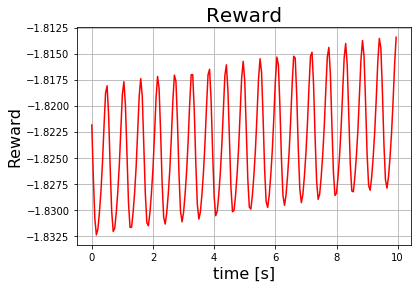

In [7]:
plt.title('Reward',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel('Reward',fontsize=16)
plt.grid()
plt.plot(time,reward_record,'r-')

## 2. Test above code from external py file

### 2.1 Test Training Env in Spinning up

In [8]:
import gym_gyroscope_env
import spinup
import torch
from custom_functions.custom_functions import env_fn 
from functools import partial

In [9]:
env_name = 'GyroscopeEnv-v0'
simu_args = {
    'dt': 0.05,
    'ep_len': 100,
    'seed': 2
}
reward_func = 'Normalized'
reward_args = {
    'k': 0.25, 
    'qx2': 0.05, 
    'qx4': 0.05, 
    'pu1': 0.05, 
    'pu2': 0.05
}
env_fn = partial(env_fn, env_name, simu_args = simu_args, reward_func = reward_func, reward_args = reward_args)

In [10]:
# spinup.ddpg_pytorch(env_fn, 
#                     ac_kwargs = dict(hidden_sizes=[400], activation=torch.nn.ReLU), 
#                     seed = 0, 
#                     steps_per_epoch = 1500, 
#                     epochs = 100, 
#                     replay_size = 1000000, 
#                     gamma = 0.99, 
#                     polyak = 0.995, 
#                     pi_lr = 0.0025,
#                     q_lr = 0.0025,
#                     batch_size = 100, 
#                     start_steps = 10000,
#                     act_noise = 0.1,
#                     max_ep_len = 100, 
#                     logger_kwargs = dict(output_dir='test_training', exp_name='test_training'))

### 2.2 Test test_agent and plot_test functions

In [11]:
from custom_functions.custom_functions import create_env
from custom_functions.custom_functions import load_agent
from custom_functions.custom_functions import test_agent
from custom_functions.custom_functions import plot_test

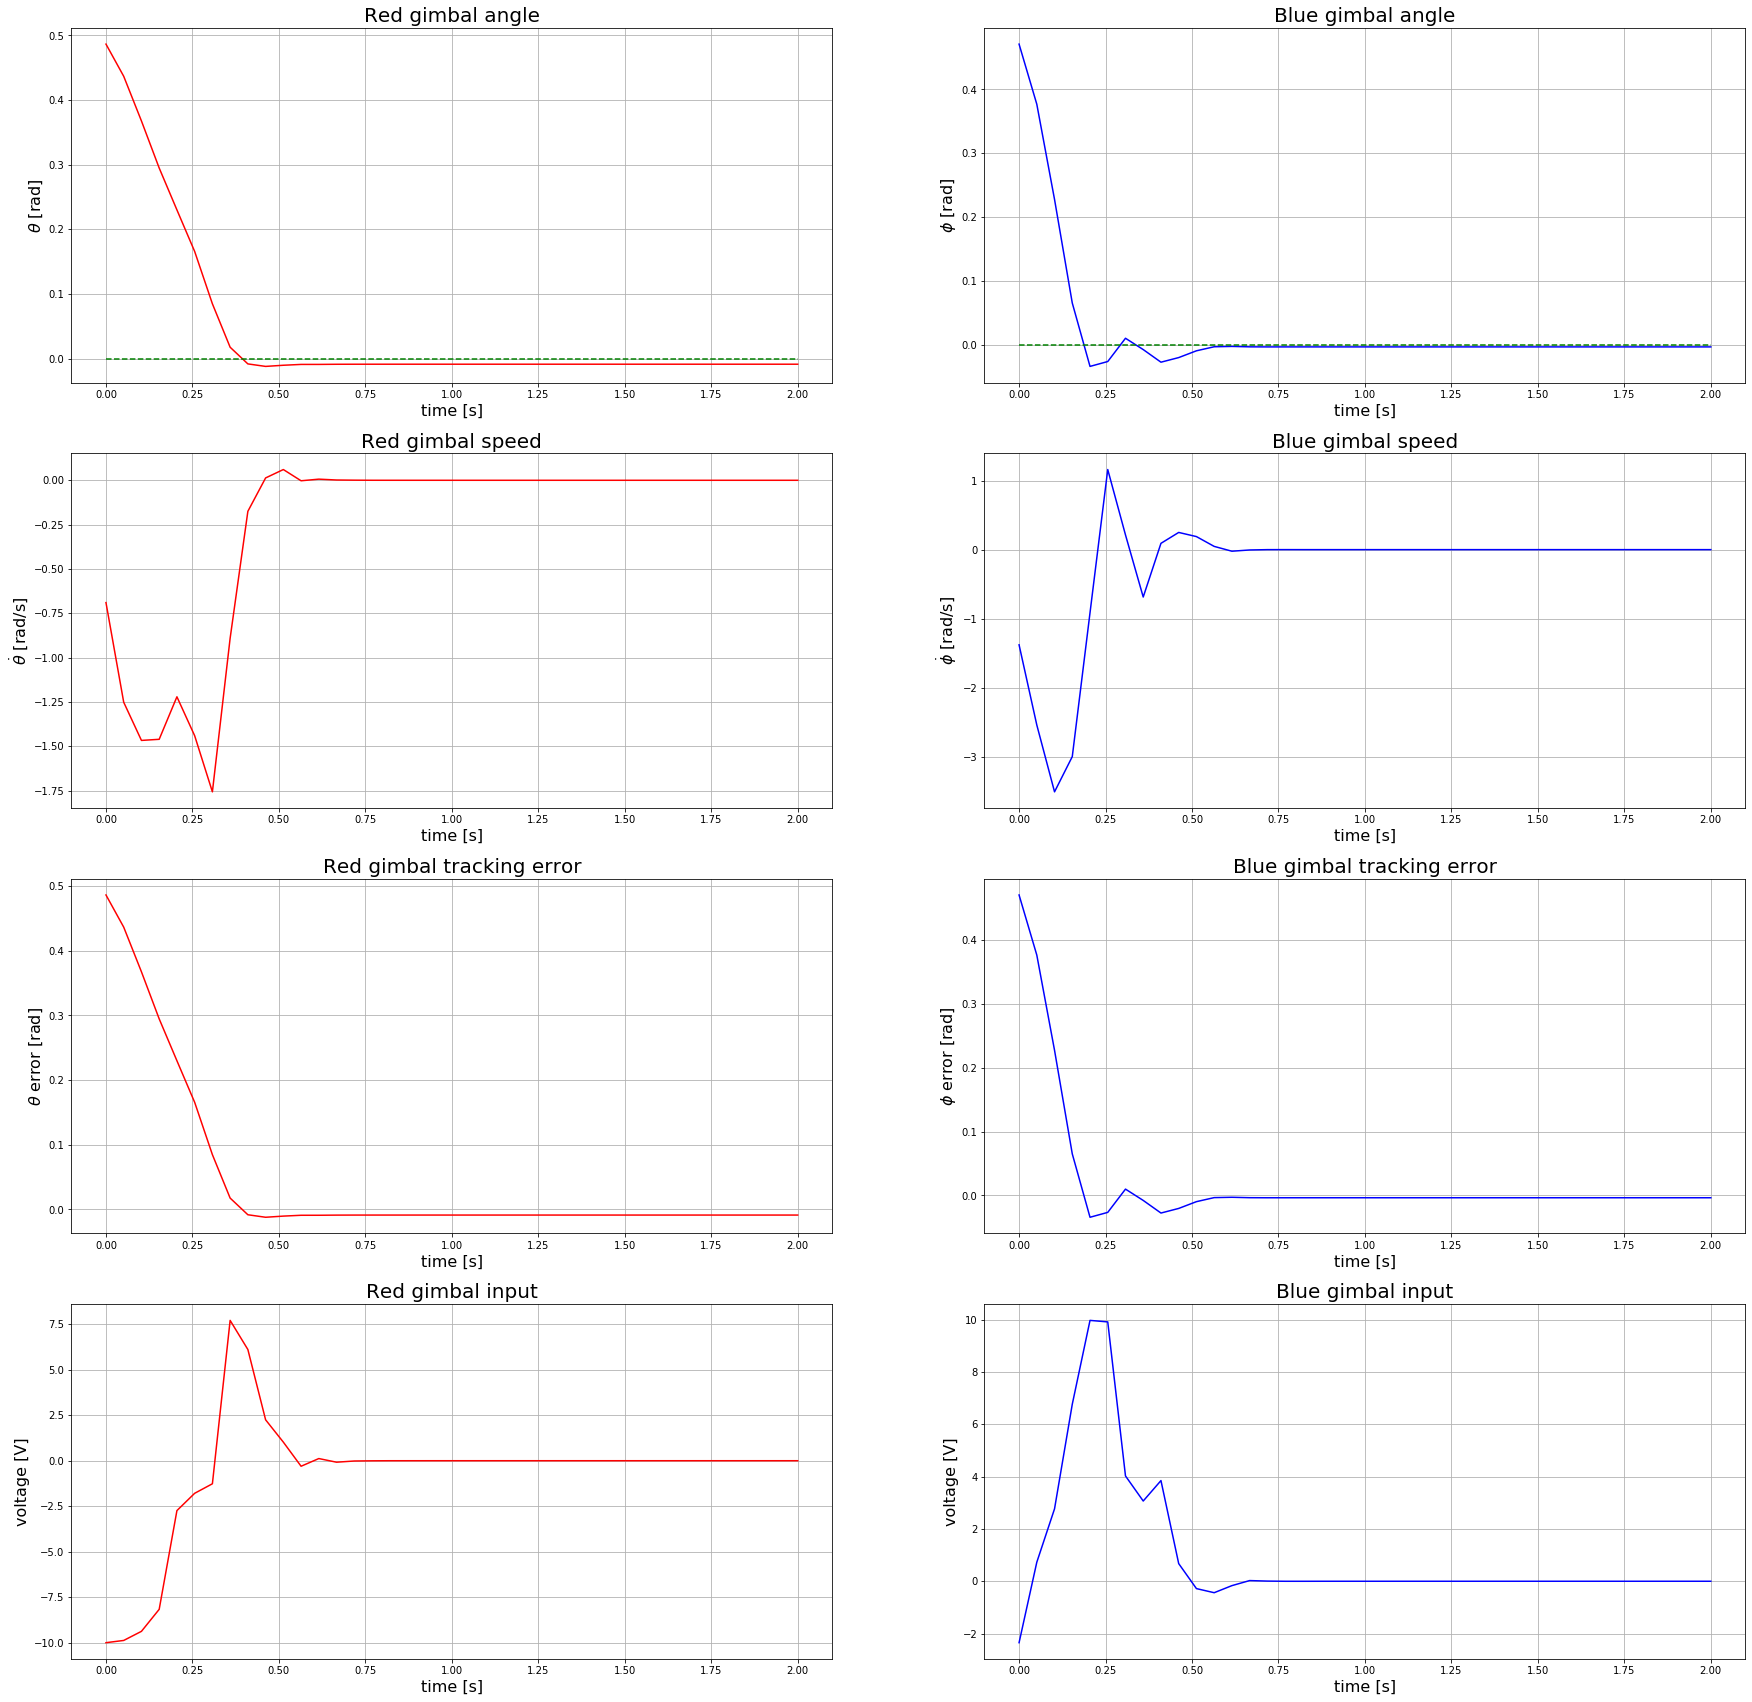

In [12]:
env_name = 'GyroscopeEnv-v0'
simu_args = {
    'dt': 0.05,
    'ep_len': 100,
    'seed': 2
}
reward_func = 'Normalized'
reward_args = {
    'k': 0.25, 
    'qx2': 0.05, 
    'qx4': 0.05, 
    'pu1': 0.05, 
    'pu2': 0.05
}
state = [0.5, 0.2, 0.5, 0, 0, 0, 200 * 2 * np.pi / 60]
env = create_env(env_name,simu_args,reward_func,reward_args,state)
# env = create_env(env_name)

agent_path = 'test_agent'
# agent_path = 'test_training'
agent = load_agent(agent_path)

t_end = 2
score, state_record, obs_record, action_record, reward_record = test_agent(env,agent,t_end)

plot_test(state_record, action_record, t_end)

### Test evaluate_control function

In [13]:
from custom_functions.custom_functions import evaluate_control

In [14]:
env_name = 'GyroscopeEnv-v0'
agent_paths = ['test_training','test_agent','linearized controller']
t_end = 5
ss_bound = 0.05

for idx, agent_path in zip(range(len(agent_paths)),agent_paths):
    env = create_env(env_name)
    agent = load_agent(agent_path)
    if idx == 0:
        metrics = evaluate_control(env,agent,agent_path,t_end,ss_bound)
    else:
        new_metrics = evaluate_control(env,agent,agent_path,t_end,ss_bound)
        metrics = metrics.append(new_metrics)

In [15]:
metrics_man = metrics.transpose()
metrics_man = metrics_man.round(4)
metrics_man

Config.,test_training,test_agent,linearized controller
$\theta$ MAE (rad),0.3894,0.1637,0.2418
$\phi$ MAE (rad),0.5074,0.1290,0.2392
$\theta$ MSSE (rad),0.1897,0.0118,0.0000
$\phi$ MSSE (rad),0.3114,0.0155,0.0000
$\theta$ in bounds (%),19.0000,99.5000,100.0000
$\phi$ in bounds (%),10.0000,99.5000,100.0000
$\theta$ unsteady (%),2.0000,0.0000,0.0000
$\phi$ unsteady (%),3.5000,0.0000,0.0000
$\theta$ rise time (s),1.0088,0.4573,0.9985
$\phi$ rise time (s),1.0758,0.3099,0.7051


## 3. Test NN implementation

### 3.1 Load the NN and its parameters

In [16]:
path = 'test_agent/pyt_save/model.pt'
ac = torch.load(path)
ac.pi.pi

Sequential(
  (0): Linear(in_features=9, out_features=700, bias=True)
  (1): ReLU()
  (2): Linear(in_features=700, out_features=70, bias=True)
  (3): ReLU()
  (4): Linear(in_features=70, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=2, bias=True)
  (7): Tanh()
)

In [17]:
# List all NN parameters
for param in ac.pi.pi.parameters():
    print(type(param), param.size())
params = list(ac.parameters())
pi_w1 = params[0].detach().numpy()
pi_b1 = params[1].detach().numpy()
pi_w2 = params[2].detach().numpy()
pi_b2 = params[3].detach().numpy()
pi_w3 = params[4].detach().numpy()
pi_b3 = params[5].detach().numpy()
pi_w4 = params[6].detach().numpy()
pi_b4 = params[7].detach().numpy()

<class 'torch.nn.parameter.Parameter'> torch.Size([700, 9])
<class 'torch.nn.parameter.Parameter'> torch.Size([700])
<class 'torch.nn.parameter.Parameter'> torch.Size([70, 700])
<class 'torch.nn.parameter.Parameter'> torch.Size([70])
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 70])
<class 'torch.nn.parameter.Parameter'> torch.Size([10])
<class 'torch.nn.parameter.Parameter'> torch.Size([2, 10])
<class 'torch.nn.parameter.Parameter'> torch.Size([2])


In [18]:
# np.savetxt('pi_w1.csv', pi_w1, delimiter=',')
# np.savetxt('pi_b1.csv', pi_b1, delimiter=',')
# np.savetxt('pi_w2.csv', pi_w2, delimiter=',')
# np.savetxt('pi_b2.csv', pi_b2, delimiter=',')
# np.savetxt('pi_w3.csv', pi_w3, delimiter=',')
# np.savetxt('pi_b3.csv', pi_b3, delimiter=',')
# np.savetxt('pi_w4.csv', pi_w4, delimiter=',')
# np.savetxt('pi_b4.csv', pi_b4, delimiter=',')

### 3.2 Test for single state

In [19]:
x_0 = [0,0,0,0,0,0,0]
observation = env.reset(x_0)

h1 = np.dot(pi_w1, observation) + pi_b1
h1 = np.maximum(h1, 0)
h2 = np.dot(pi_w2, h1) + pi_b2
h2 = np.maximum(h2, 0)
h3 = np.dot(pi_w3, h2) + pi_b3
h3 = np.maximum(h3, 0)
y = np.dot(pi_w4, h3) + pi_b4
y = np.tanh(y)

print("observation =", observation)
print("NN implementation output =", y)
print("Spinning up output =", ac.act(torch.as_tensor(observation, dtype=torch.float32)))

observation = [1. 0. 0. 1. 0. 0. 0. 0. 0.]
NN implementation output = [0.12735992 0.11435266]
Spinning up output = [0.12736006 0.11435263]


### 3.3 Test for a time period

In [20]:
env.reset()
time = np.arange(0, 10, env.dt)
state_record = np.empty([len(time), len(x_0)])
reward_record = np.empty([len(time), 1])
action_record = np.empty([len(time), 2])
action_nn_record = np.empty([len(time), 2])

for i in range(len(time)):
    action = ac.act(torch.as_tensor(observation, dtype=torch.float32))
    
    h1 = np.dot(pi_w1, observation) + pi_b1
    h1 = np.maximum(h1, 0)
    h2 = np.dot(pi_w2, h1) + pi_b2
    h2 = np.maximum(h2, 0)
    h3 = np.dot(pi_w3, h2) + pi_b3
    h3 = np.maximum(h3, 0)
    y = np.dot(pi_w4, h3) + pi_b4
    y = np.tanh(y)
    
    observation, reward, done, info = env.step(action)
    state_record[i] = env.state
    reward_record[i] = reward
    action_record[i] = action
    action_nn_record[i] = y

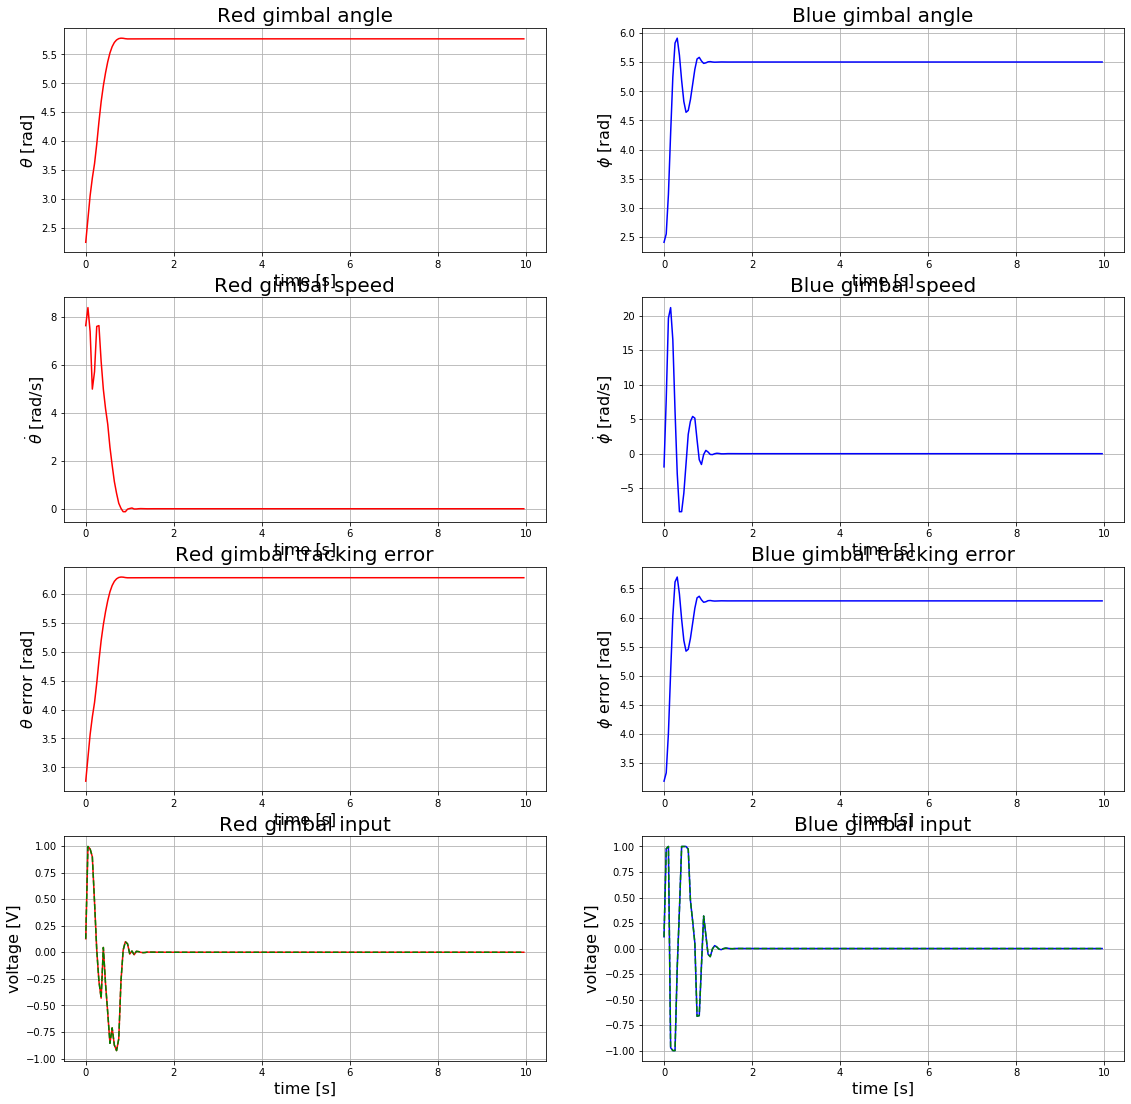

In [21]:
f, axs = plt.subplots(4,2,figsize=(19,19))

plt.subplot(4,2,1)
plt.title('Red gimbal angle',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\theta$ [rad]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,0],'r-')

plt.subplot(4,2,2)
plt.title('Blue gimbal angle',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\phi$ [rad]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,2],'b-')

plt.subplot(4,2,3)
plt.title('Red gimbal speed',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\dot \theta$ [rad/s]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,1],'r-')

plt.subplot(4,2,4)
plt.title('Blue gimbal speed',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\dot \phi$ [rad/s]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,3],'b-')

plt.subplot(4,2,5)
plt.title('Red gimbal tracking error',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\theta$ error [rad]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,0]-state_record[:,4],'r-')

plt.subplot(4,2,6)
plt.title('Blue gimbal tracking error',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\phi$ error [rad]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,2]-state_record[:,5],'b-')

plt.subplot(4,2,7)
plt.title('Red gimbal input',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel('voltage [V]',fontsize=16)
plt.grid()
plt.plot(time,action_record[:,0],'r-')
plt.plot(time,action_nn_record[:,0],'g--')

plt.subplot(4,2,8)
plt.title('Blue gimbal input',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel('voltage [V]',fontsize=16)
plt.grid()
plt.plot(time,action_record[:,1],'b-')
plt.plot(time,action_nn_record[:,1],'g--')

plt.show()

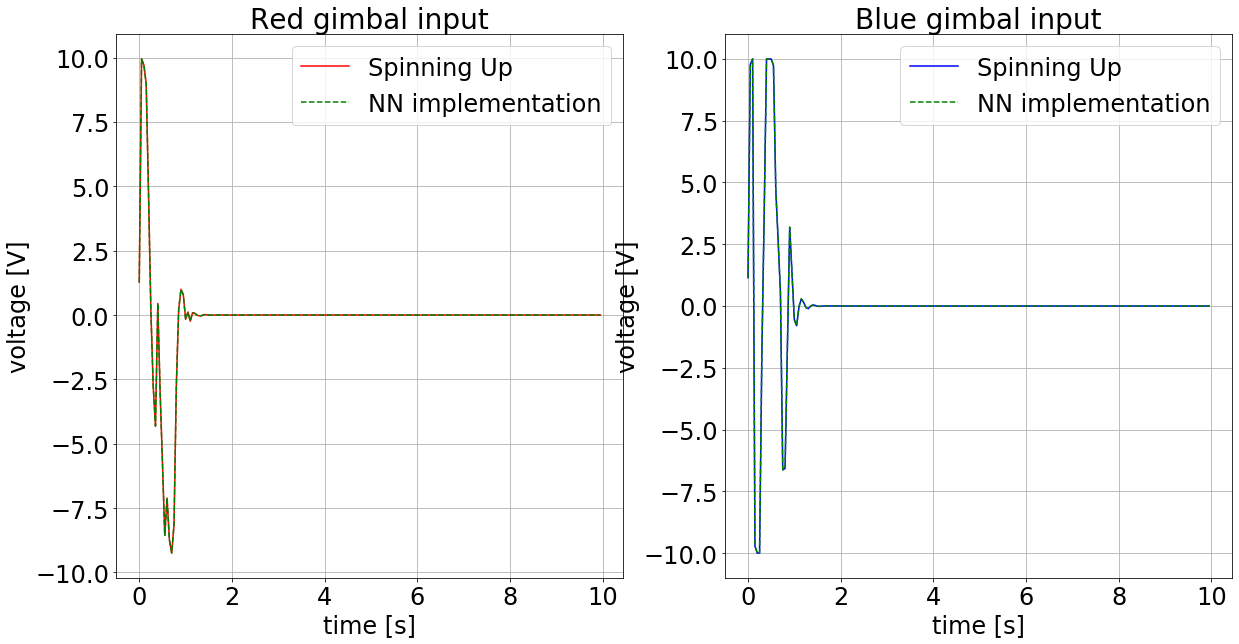

In [22]:
# save last 2 subfigs

f, axs = plt.subplots(1,2,figsize=(20,10))

plt.subplot(1,2,1)
plt.title('Red gimbal input',fontsize=28)
plt.xlabel('time [s]',fontsize=24)
plt.xticks(fontsize=24)
plt.ylabel('voltage [V]',fontsize=24)
plt.yticks(fontsize=24)
plt.grid()
plt.plot(time,action_record[:,0]*10,'r-')
plt.plot(time,action_nn_record[:,0]*10,'g--')
plt.legend(['Spinning Up', 'NN implementation'],fontsize=24)

plt.subplot(1,2,2)
plt.title('Blue gimbal input',fontsize=28)
plt.xlabel('time [s]',fontsize=24)
plt.xticks(fontsize=24)
plt.ylabel('voltage [V]',fontsize=24)
plt.yticks(fontsize=24)
plt.grid()
plt.plot(time,action_record[:,1]*10,'b-')
plt.plot(time,action_nn_record[:,1]*10,'g--')
plt.legend(['Spinning Up', 'NN implementation'],fontsize=24)

plt.savefig('NN implementation')

plt.show()